In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


On a donc 1 an et 1 semaine de donnée

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Analyse des Features

### Exploration des features

In [7]:
generator = (x for x in df)

In [8]:
col = next(generator)
print(col)
print(df[col].value_counts(), "\n")
print(len(df[df[col].isnull()]), "\n")
print(df[col].describe(), "\n")

InvoiceNo
573585     1114
581219      749
581492      731
580729      721
558475      705
579777      687
581217      676
537434      675
580730      662
538071      652
580367      650
580115      645
581439      635
580983      629
578344      622
538349      620
578347      606
537638      601
537237      597
576617      593
536876      593
536592      592
537823      591
576837      585
579508      578
577078      572
537240      568
577358      561
576618      552
576840      544
           ... 
560941        1
C554525       1
C544570       1
C559417       1
542615        1
C567867       1
559825        1
542563        1
542573        1
542564        1
542565        1
542566        1
542567        1
C566748       1
542569        1
542570        1
542571        1
542572        1
542574        1
578196        1
542575        1
542576        1
542577        1
578192        1
542579        1
542580        1
542581        1
542582        1
C552423       1
556417        1
Name: InvoiceN

### Gestion des invoice cancelled ou non

Les ventes cancelled ont un C en 1ere lettre, on va donc creer une nouvelle feature pour gérer les annulations. Par la suite on va pouvoir re-convertir les numéros de vente en int

In [9]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

In [10]:
df[df["Cancelled"] == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,True
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom,True


Comme une facture annulée a aussi un numéro unique, on a mainteant extrait les cancellation dans une feature additionnelle, on peut donc convertir ces invoices en un numéro aussi

In [11]:
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

### StockCode

On ne peut pas faire grand chose avec les stocks code. On remarque juste une similarité des article en foncton de leur clé.

In [12]:
df[["StockCode", "Description"]].head(20)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
5,22752,SET 7 BABUSHKA NESTING BOXES
6,21730,GLASS STAR FROSTED T-LIGHT HOLDER
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT


De ce fait, on va utiliser les articles pour le classification et on peut supprimer cette feature

### Description

Au niveau description, on remarque que la majorité sont en Majuscule sauf certains en minuscule ou avec ???. On va donc creuser un peu

In [13]:
df["Description"].str.islower().sum()

493

In [14]:
df[df["Description"].str.islower() == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom,False
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom,False
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom,False
15651,537639,22734,amazon,30,2010-12-07 15:29:00,0.0,NaN,United Kingdom,False
21338,538072,22423,faulty,-13,2010-12-09 14:10:00,0.0,NaN,United Kingdom,False
24290,538348,22734,amazon,30,2010-12-10 14:59:00,0.0,NaN,United Kingdom,False
30555,538873,22734,amazon sales,20,2010-12-14 15:13:00,0.0,NaN,United Kingdom,False
42564,540010,22501,reverse 21/5/10 adjustment,-100,2011-01-04 11:13:00,0.0,NaN,United Kingdom,False


In [15]:
df[df["Description"].str.startswith("?") == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom,False
21518,538090,20956,?,-723,2010-12-09 14:48:00,0.0,NaN,United Kingdom,False
38261,539494,21479,?,752,2010-12-20 10:36:00,0.0,NaN,United Kingdom,False
43662,540100,22837,?,-106,2011-01-04 16:53:00,0.0,NaN,United Kingdom,False
50806,540558,21258,?,-29,2011-01-10 10:04:00,0.0,NaN,United Kingdom,False
51673,540651,82599,?,-290,2011-01-10 15:00:00,0.0,NaN,United Kingdom,False
68920,541882,48185,?,-57,2011-01-24 10:54:00,0.0,NaN,United Kingdom,False
78235,542861,47591B,?,-207,2011-02-01 11:47:00,0.0,NaN,United Kingdom,False
94765,544410,84997C,?,-741,2011-02-18 13:54:00,0.0,NaN,United Kingdom,False
97643,544649,21621,?,-400,2011-02-22 12:37:00,0.0,NaN,United Kingdom,False


C'est toujours Nan en Client donc c'est surement le magasin, on peut donc supprimer les lignes

In [16]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]

# ajouté suite exploration
df = df[df["Description"].str.contains("LOST") == False]

On peut maintenant regarder s'il reste des vente faite à Nan

In [17]:
df[df["CustomerID"].isnull()][["InvoiceNo","Description"]]

,InvoiceNo,Description
1443,536544,DECORATIVE ROSE BATHROOM BOTTLE
1444,536544,DECORATIVE CATS BATHROOM BOTTLE
1445,536544,POLKADOT RAIN HAT
1446,536544,RAIN PONCHO RETROSPOT
1447,536544,VINTAGE SNAP CARDS
1448,536544,VINTAGE HEADS AND TAILS CARD GAME
1449,536544,CHRISTMAS TREE DECORATION WITH BELL
1450,536544,CHRISTMAS TREE HEART DECORATION
1451,536544,CHRISTMAS TREE STAR DECORATION
1452,536544,CHRISTMAS HANGING TREE WITH BELL


On remarque de ce sont beaucoup des gros acahts donc potentiellement fait par le magasin pour de la decoration apr exemple ou pour refaire l'inventaire à cause de vols

In [18]:
df = df[df["CustomerID"].notnull()]

### InvoiceDate

On peut decouper la date par jour/moment de la journée (matin/midi/apres midi)

In [19]:
df["Weekday"] = df["InvoiceDate"].dt.weekday

In [20]:
df["Time"] = df["InvoiceDate"].dt.hour

In [21]:
def convert_to_moment(x):
    if 6 <= x <12:
        return "Morning"
    elif 12 <= x < 17:
        return "Afternoon"
    elif 17 <= x <=20:
        return "Late"

df["Time"] = df["Time"].apply(convert_to_moment)

In [22]:
df = pd.concat([df, pd.get_dummies(df['Time'])], axis=1)

In [23]:
df.drop("Time", axis=1, inplace=True)

In [24]:
now = df["InvoiceDate"].max()
df["Recency"] = now-df["InvoiceDate"]
df["Recency"] = pd.to_timedelta(df["Recency"]).astype("timedelta64[D]")

In [25]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,2,0,0,1,373.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2,0,0,1,373.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,2,0,0,1,373.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2,0,0,1,373.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2,0,0,1,373.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,False,2,0,0,1,373.0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,False,2,0,0,1,373.0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,False,2,0,0,1,373.0
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,False,2,0,0,1,373.0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,False,2,0,0,1,373.0


### Prix dépensé dans chaque objets

In [26]:
df["Price"] = df["UnitPrice"] * df["Quantity"]

### UnitPrice

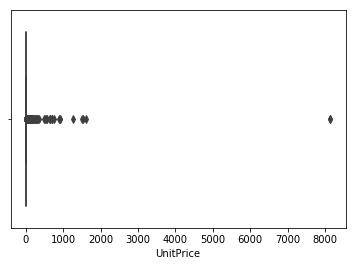

In [27]:
sns.boxplot(df["UnitPrice"])

In [28]:
df[df["UnitPrice"]>500]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
173277,551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,True,1,1,0,0,219.0,-8142.75
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,False,1,1,0,0,219.0,8142.75
187584,552980,POST,POSTAGE,1,2011-05-12 14:52:00,523.00,12590.0,Germany,False,3,1,0,0,210.0,523.00
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,False,4,1,0,0,181.0,38970.00
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom,False,4,1,0,0,181.0,649.50
235379,557638,POST,POSTAGE,-1,2011-06-21 16:01:00,545.58,17450.0,United Kingdom,True,1,1,0,0,170.0,-545.58
236402,557754,POST,POSTAGE,1,2011-06-22 13:12:00,700.00,12432.0,Norway,False,2,1,0,0,169.0,700.00
264976,560187,POST,POSTAGE,1,2011-07-15 12:05:00,550.94,17444.0,Canada,False,4,1,0,0,147.0,550.94
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,False,2,1,0,0,78.0,878.55
361584,568346,DOT,DOTCOM POSTAGE,1,2011-09-26 15:28:00,688.08,14096.0,United Kingdom,False,0,1,0,0,73.0,688.08


In [29]:
df[df["StockCode"] == "DOT"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,False,1,0,0,1,101.0,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,False,4,1,0,0,97.0,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,False,4,1,0,0,90.0,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,False,1,1,0,0,87.0,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,False,2,1,0,0,78.0,878.55
361584,568346,DOT,DOTCOM POSTAGE,1,2011-09-26 15:28:00,688.08,14096.0,United Kingdom,False,0,1,0,0,73.0,688.08
372766,569246,DOT,DOTCOM POSTAGE,1,2011-10-03 09:57:00,490.25,14096.0,United Kingdom,False,0,0,0,1,67.0,490.25
389983,570488,DOT,DOTCOM POSTAGE,1,2011-10-10 17:12:00,635.01,14096.0,United Kingdom,False,0,0,1,0,59.0,635.01
401766,571441,DOT,DOTCOM POSTAGE,1,2011-10-17 13:31:00,743.62,14096.0,United Kingdom,False,0,1,0,0,52.0,743.62
416463,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,638.30,14096.0,United Kingdom,False,0,0,1,0,45.0,638.30


In [30]:
df[df["InvoiceNo"] == 551697 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,False,1,1,0,0,219.0,8142.75


StockCode DOT représente les coups d'envoi au Royaume Uni (via DOTCOM POSTAGE) et POST concerne les envois à l'étranger. Comme ces couts ne représente pas vraimenet les vente mais sont juste la pour compenser les frais d'envoi, on va supprimer ces lignes.

In [31]:
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]

### Gestion CustomerID/Country

On peut regarder la nationalité des clients. Elle sera comparé au CA. Si 10% des clients sont étrangers mais rapportent 30% du CA, ca vaut le coup de les garder

In [32]:
repartition = df.groupby("Country").agg({
    "InvoiceNo" : "count"
}).sort_values("InvoiceNo").reset_index()

In [33]:
repartition

,Country,InvoiceNo
0,Saudi Arabia,10
1,Bahrain,17
2,Czech Republic,28
3,Brazil,32
4,Lithuania,35
5,Lebanon,45
6,RSA,57
7,European Community,58
8,United Arab Emirates,67
9,Malta,123


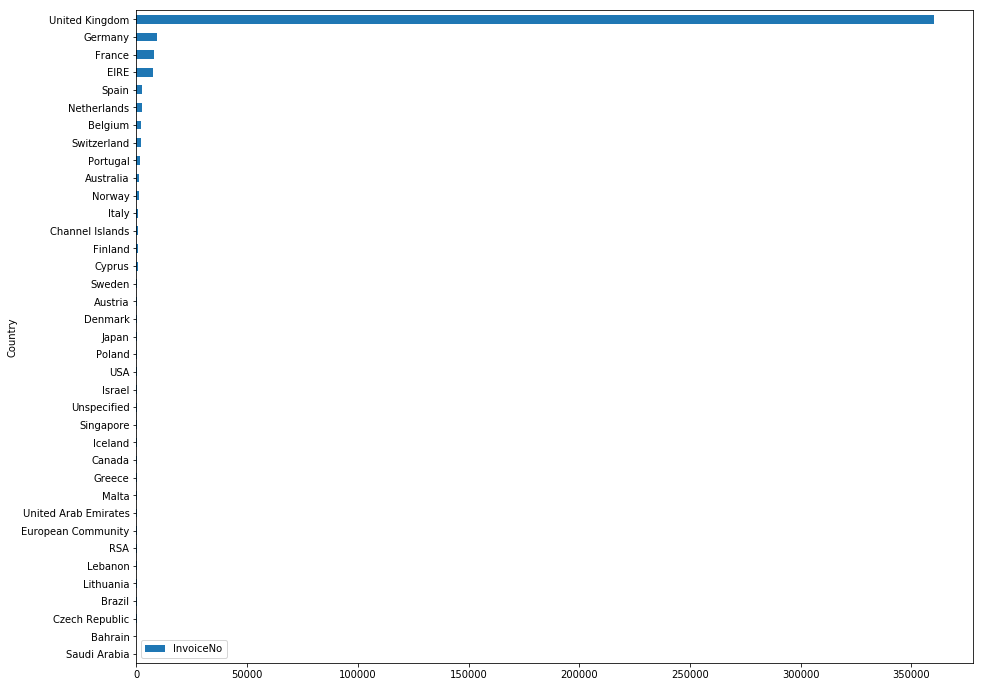

In [34]:
repartition.set_index("Country").plot(kind='barh', figsize=(15,12))
plt.show()

In [35]:
repartition[repartition["Country"] == "United Kingdom"]["InvoiceNo"].values/repartition["InvoiceNo"].sum()

array([ 0.89183304])

89 % des clients sont au Royaume Uni. Afin de savoir si l'on peut supprimer les clients hors Royaume-Uni, on peut regarder leur apport dans le CA

In [36]:
CA_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()

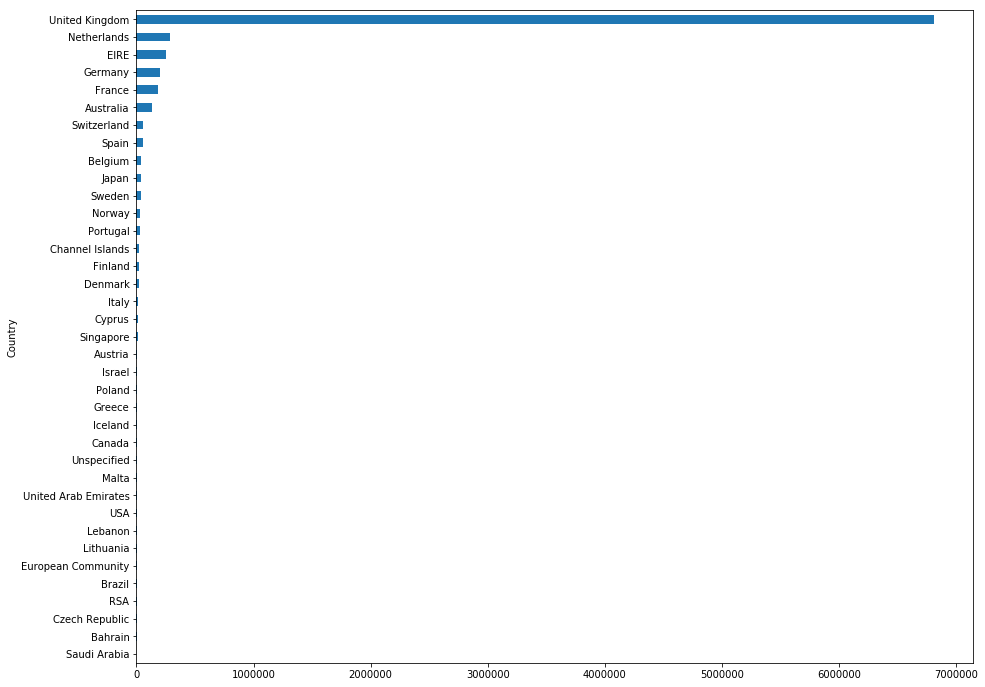

In [37]:
CA_per_countries.plot(kind='barh', figsize=(15,12))
plt.show()

In [38]:
CA_per_countries["United Kingdom"]/CA_per_countries.sum()

0.82263452551421146

18 % des revenues sont étrangers, il faut donc les garder. Pour l'encoding, on va utiliser leur calssement en apport

In [39]:
print(list(CA_per_countries.index[::-1]))

['United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France', 'Australia', 'Switzerland', 'Spain', 'Belgium', 'Japan', 'Sweden', 'Norway', 'Portugal', 'Channel Islands', 'Finland', 'Denmark', 'Italy', 'Cyprus', 'Singapore', 'Austria', 'Israel', 'Poland', 'Greece', 'Iceland', 'Canada', 'Unspecified', 'Malta', 'United Arab Emirates', 'USA', 'Lebanon', 'Lithuania', 'European Community', 'Brazil', 'RSA', 'Czech Republic', 'Bahrain', 'Saudi Arabia']


On peut maintenant encoder le dataset en fonction de leur classement

In [40]:
decoder_countries = {i: j for i, j in enumerate(CA_per_countries.index[::-1]) }
encoder_countries = {j: i for i, j in enumerate(CA_per_countries.index[::-1]) }

In [41]:
df["Country"] = df["Country"].apply(lambda x:encoder_countries[x])

C:\Anaconda501\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Description

Les mot clé seront difficilement gérable et parfois menant sur des fausses pistes ( ex avec les couleurs). Du coup on va s'ocduper des données pour faire un OHE. L'objectif étant de grouper les objets similaires (exemple une table blanche et une table rouge)

<ul>
<li>22              RED COAT RACK PARIS FASHION</li>
<li>23           YELLOW COAT RACK PARIS FASHION</li>
<li>24             BLUE COAT RACK PARIS FASHION</li>
</ul>

<ul>
<li>3887              LETTER "F" BLING KEY RING</li>
<li>3888              LETTER "O" BLING KEY RING</li>
<li>3889              LETTER "T" BLING KEY RING</li>
<li>3890              LETTER "U" BLING KEY RING</li>
<li>3891              LETTER "W" BLING KEY RING</li>
<li>3892              LETTER "Z" BLING KEY RING</li>
</ul>

In [42]:
df_obj = df["Description"].drop_duplicates().reset_index(drop=True).to_frame()

In [43]:
df_obj["Keywords"] = df_obj["Description"]

In [44]:
df_obj

,Description,Keywords
0,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.
5,SET 7 BABUSHKA NESTING BOXES,SET 7 BABUSHKA NESTING BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK,HAND WARMER UNION JACK
8,HAND WARMER RED POLKA DOT,HAND WARMER RED POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR BIRD ORNAMENT


In [45]:
df_obj["Keywords"].drop_duplicates()

0        WHITE HANGING HEART T-LIGHT HOLDER
1                       WHITE METAL LANTERN
2            CREAM CUPID HEARTS COAT HANGER
3       KNITTED UNION FLAG HOT WATER BOTTLE
4            RED WOOLLY HOTTIE WHITE HEART.
5              SET 7 BABUSHKA NESTING BOXES
6         GLASS STAR FROSTED T-LIGHT HOLDER
7                    HAND WARMER UNION JACK
8                 HAND WARMER RED POLKA DOT
9             ASSORTED COLOUR BIRD ORNAMENT
10               POPPY'S PLAYHOUSE BEDROOM 
11                POPPY'S PLAYHOUSE KITCHEN
12        FELTCRAFT PRINCESS CHARLOTTE DOLL
13                  IVORY KNITTED MUG COSY 
14       BOX OF 6 ASSORTED COLOUR TEASPOONS
15            BOX OF VINTAGE JIGSAW BLOCKS 
16           BOX OF VINTAGE ALPHABET BLOCKS
17                 HOME BUILDING BLOCK WORD
18                 LOVE BUILDING BLOCK WORD
19              RECIPE BOX WITH METAL HEART
20                      DOORMAT NEW ENGLAND
21                 JAM MAKING SET WITH JARS
22              RED COAT RACK PA

In [46]:
keywords = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
a = 0
for index, word in keywords.iteritems():
    print(index)


PINK
SET
OF
HEART
VINTAGE
BLUE
RED
BAG
GLASS
CHRISTMAS
BOX
WHITE
DESIGN
HOLDER
SMALL
FLOWER
METAL
LARGE
HANGING
DECORATION
ROSE
WALL
RETROSPOT
BLACK
GREEN
CANDLE
3
T-LIGHT
NECKLACE
PAPER
CAKE
SILVER
WITH
AND
ART
CARD
POLKADOT
IN
GARDEN
COVER
MUG
4
WRAP
PACK
IVORY
SIGN
BRACELET
6
ASSORTED
12
MINI
EGG
STAR
LOVE
TEA
TREE
BOWL
GIFT
CUSHION
CREAM
FRAME
EARRINGS
MIRROR
HOME
ZINC
EASTER
WOODEN
RING
CRYSTAL
CLOCK
BIRD
CERAMIC
TIN
PARTY
PAISLEY
GIRL
W
BOTTLE
CANDLES
DOLLY
2
WOOD
GOLD
GARLAND
ANTIQUE
HOOK
JAR
FRENCH
DIAMANTE
KEY
SPACEBOY
PHOTO
ENAMEL
FELT
CUP
STAND
FAIRY
COLOUR
BUTTERFLY
SWEETHEART
CUTLERY
ROUND
BIRTHDAY
PURPLE
TRAY
DRAWER
PANTRY
PAINTED
CHARM
PLATE
BEAD
NOTEBOOK
LETTER
HEARTS
&
HOT
TILE
KIT
CHOCOLATE
RETRO
JUMBO
RABBIT
WATER
CASES
UNION
DOORMAT
LUNCH
WOODLAND
GINGHAM
TABLE
CHILDRENS
STORAGE
KITCHEN
MAGIC
BLING
STRAWBERRY
PENCILS
FLOCK
HAIR
POT
SPOT
DROP
BELL
FELTCRAFT
36
TINS
SWEET
LONDON
PURSE
LANTERN
BABUSHKA
DAISY
BUNNY
TRINKET
MAGNETS
TUBE
BASKET
CABINET
DOG
BAROQUE
ON
WIR

In [47]:
df_obj[df_obj["Keywords"].str.contains(" YOU ")].drop_duplicates()

,Description,Keywords
704,IF YOU CAN'T STAND THE HEAT MUG,IF YOU CAN'T STAND THE HEAT MUG
980,TOAST ITS - I LOVE YOU,TOAST ITS - I LOVE YOU
3819,DOILY THANK YOU CARD,DOILY THANK YOU CARD
3820,A PRETTY THANK YOU CARD,A PRETTY THANK YOU CARD


In [48]:
pat = r"RED|BLUE|PINK|BLACK|WHITE|GREEN|ROSE|SILVER|IVORY|YELLOW|LAVENDER|TURQUOISE|PURPLE|ORANGE|BROWN"  # suppression couleurs
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [49]:
pat = r"LARGE|MEDIUM|SMALL"  # suppresion taille
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [50]:
pat = r"OF|THE|IN|AND|WITH|ON|TO"  # suppresion mot fréquents inutile
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [51]:
df_obj["Keywords"] = df_obj["Keywords"].str.replace("CLES", "CLE")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("HEARTS", "HEART")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("'S", "")

In [52]:
pat = r"[a-z]+" # suppression des keywords en minuscule
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [53]:
pat = r"\d" # suppression des chiffres
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [54]:
# pat = r"\W+"
# df_obj = df_obj.str.replace(pat, " ")

In [55]:
pat = r"[,.!&/+\"]"  # suppression de caractères spécieux
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [56]:
pat = r"\s[A-Z]\s"
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, "")

In [57]:
pat = r"\s+"  # suppression des double espaces
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [58]:
df_obj["Keywords"] = df_obj["Keywords"].str.strip()

In [59]:
df_obj

,Description,Keywords
0,WHITE HANGING HEART T-LIGHT HOLDER,HANGG HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN,METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEART COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNI FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.,WOOLLY HOTTIE HEART
5,SET 7 BABUSHKA NESTING BOXES,SET BABUSHKA NESTG BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK,H WARMER UNI JACK
8,HAND WARMER RED POLKA DOT,H WARMER POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR BIRD ORNAMENT


In [90]:
# pat = r".*T-LIGHT HOLDER.*"
# df_obj = df_obj.str.replace(pat, 'T-LIGHT HOLDER')

In [150]:
# pat = r".*(NECKLACE|BAG CHARM|BRACELET|GLOVES?).*"
# df_obj = df_obj.str.replace(pat, r'\1')

# pat = r".*GLOVES?.*"
# df_obj = df_obj.str.replace(pat, r'GLOVES')

In [92]:
# pat = r".*(JUMBO|CHARLOTTE|LUNCH|SHOULDER|GIFT|SHOPPER).*BAG.*"
# df_obj = df_obj.str.replace(pat, r'\1 BAG')

In [102]:
# pat = r".*(CARDS?|MUG).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [112]:
# pat = r".*(BON BON|SWEET|JAM).*JAR.*"
# df_obj = df_obj.str.replace(pat, r'\1 JAR')

In [116]:
# pat = r".*(CAKE CASES).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [155]:
# pat = r".*(POPPY S PLAYHOUSE|BUILDG BLOCK WORD|SNACK TRAY).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [129]:
# pat = r".*(CUSHION|PASSPORT|FOOD).*COVER.*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

# pat = r".*COVER.*(CUSHION|PASSPORT|FOOD).*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

Certaines regexp n'ont pas été utilisées car elles réduisent peu les dimensionset font parfois perdre pas mal de sens. On ne peut pas tel quel utiliser un OHE car on aurait 400 000 x 3500 données. Par contre, on peut encoder le l'objet par rapport au OHE des mots clés en gardant l'ensemble des mots clé utilisé dans par exemple 95 % des cas

In [61]:
keywords = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)

In [62]:
CS = keywords.cumsum().reset_index()
CS.columns = ["keyword", "CS"]
CS

,keyword,CS
0,SET,336.0
1,HEART,600.0
2,VTAGE,803.0
3,GLASS,965.0
4,BAG,1123.0
5,CHRISTMAS,1271.0
6,CLE,1408.0
7,BOX,1543.0
8,DESIGN,1669.0
9,HOLDER,1785.0


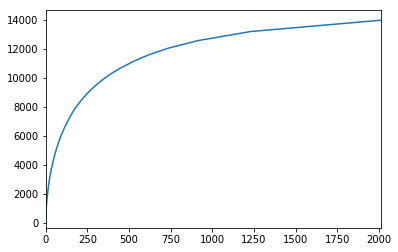

In [63]:
CS['CS'].plot()

In [64]:
limite = CS['CS'].values.max()*0.95
index_max = (CS["CS"]<limite).sum()
index_max

1311

In [65]:
keywords_selected = CS["keyword"].tolist()[:index_max]

In [66]:
unique_key_obj = df_obj["Keywords"].drop_duplicates().to_frame()

In [67]:
unique_key_obj

,Keywords
0,HANGG HEART T-LIGHT HOLDER
1,METAL LANTERN
2,CREAM CUPID HEART COAT HANGER
3,KNITTED UNI FLAG HOT WATER BOTTLE
4,WOOLLY HOTTIE HEART
5,SET BABUSHKA NESTG BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER
7,H WARMER UNI JACK
8,H WARMER POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT


In [68]:
for key in keywords_selected:
    unique_key_obj[key] = 0

In [69]:
unique_key_obj

,Keywords,SET,HEART,VTAGE,GLASS,BAG,CHRISTMAS,CLE,BOX,DESIGN,...,CRYSTALS,STRUMENT,STRIPY,UTILTY,YOU'RE,STRGMAN,XMAS,BERRY,XIC,BIRDY
0,HANGG HEART T-LIGHT HOLDER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,METAL LANTERN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CREAM CUPID HEART COAT HANGER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,KNITTED UNI FLAG HOT WATER BOTTLE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WOOLLY HOTTIE HEART,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,SET BABUSHKA NESTG BOXES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,GLASS STAR FROSTED T-LIGHT HOLDER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,H WARMER UNI JACK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,H WARMER POLKA DOT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ASSORTED COLOUR BIRD ORNAMENT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
for index, row in unique_key_obj.iterrows():
    for word in row["Keywords"].split(" "):
        if word in keywords_selected:
            unique_key_obj.loc[index, word] = 1

In [71]:
unique_key_obj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 0 to 3870
Columns: 1312 entries, Keywords to BIRDY
dtypes: int64(1311), object(1)
memory usage: 33.6+ MB


In [72]:
X = unique_key_obj.drop("Keywords", axis=1)

Comme notre matrice est un OHE, on n'a pas besoinde  faire de Scaling. On peut appliquer directement le Kmeans. En fonction du facteur de silhoutette on va choisir le nb de cluster pour notre modèles. 

In [74]:
from sklearn.metrics import silhouette_score
for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.0423638678704
For n_clusters = 4 The average silhouette_score is : 0.0419209572045
For n_clusters = 5 The average silhouette_score is : 0.0495077845657
For n_clusters = 6 The average silhouette_score is : 0.0358891011911
For n_clusters = 7 The average silhouette_score is : 0.0499366921251
For n_clusters = 8 The average silhouette_score is : 0.0464324818345
For n_clusters = 9 The average silhouette_score is : 0.0312575193558
For n_clusters = 10 The average silhouette_score is : 0.0263083915072
For n_clusters = 11 The average silhouette_score is : 0.0371315016338
For n_clusters = 12 The average silhouette_score is : 0.0575047106
For n_clusters = 13 The average silhouette_score is : 0.0524479606895
For n_clusters = 14 The average silhouette_score is : 0.0428693502324


In [75]:
kmeans = KMeans(init='k-means++', n_clusters = 10, n_init=30)
kmeans.fit(X)
unique_key_obj["Cluster"] = kmeans.labels_ 
X_embedded = kmeans.fit_transform(X)

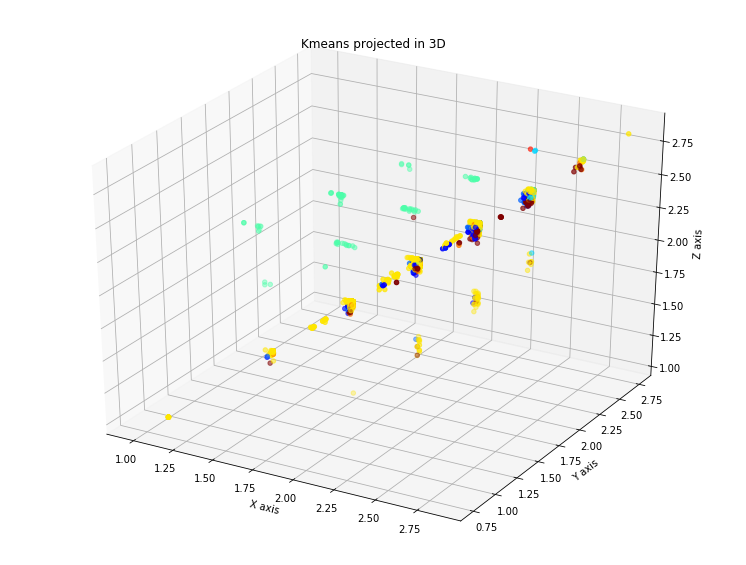

In [76]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
plt.title("Kmeans projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/kmeans3d_obj.png")
plt.show()

In [77]:
df_obj = df_obj.set_index('Keywords').join(unique_key_obj[["Keywords", "Cluster"]].set_index('Keywords')).reset_index()

In [78]:
df_obj[df_obj["Cluster"] == 3]

,Keywords,Description,Cluster
25,AGED GLASS T-LIGHT HOLDER,AGED GLASS SILVER T-LIGHT HOLDER,3
91,ANTIQUE T-LIGHT GLASS,ANTIQUE SILVER T-LIGHT GLASS,3
130,ASSORTED COLOUR T-LIGHT HOLDER,ASSORTED COLOUR T-LIGHT HOLDER,3
217,BEADED CHELIER T-LIGHT HOLDER,BEADED CHANDELIER T-LIGHT HOLDER,3
256,BIRDCAGE DECORATI TEALIGHT HOLDER,BIRDCAGE DECORATION TEALIGHT HOLDER,3
281,BNE JAM JAR T-LIGHT HOLDER,SMALL BONNE JAM JAR T-LIGHT HOLDER,3
282,BNE JAM JAR T-LIGHT HOLDER,LARGE BONNE JAM JAR T-LIGHT HOLDER,3
301,BOUDOIR T-LIGHT HOLDER,PINK BOUDOIR T-LIGHT HOLDER,3
449,CELABRA T-LIGHT HOLDER,BLACK CANDELABRA T-LIGHT HOLDER,3
510,CHELIER T-LIGHT HOLDER,IVORY CHANDELIER T-LIGHT HOLDER,3


In [79]:
df_obj.to_csv("object_to_cluster.csv")

On peut donc ajouter le cluster au dataset initial

In [80]:
df = df.set_index("Description").join(df_obj[["Description", "Cluster"]].set_index('Description')).reset_index()

### Quantity

Sur cette feature il n'y a pas grand chose a dire non plus, on a le prix unitaire et le nombre acheté. Les acaht négatifs sont les achat cancelled donc on en a plus si on filtre les acaht réellement fait. 

In [81]:
df[df["Cancelled"] == False]["Quantity"].describe()

count    395147.000000
mean         13.019659
std         180.876808
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

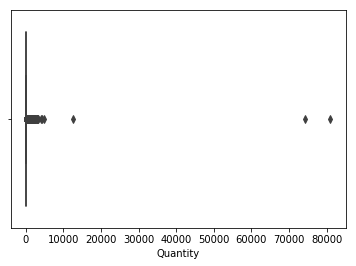

In [82]:
sns.boxplot(df[df["Cancelled"] == False]["Quantity"])

On peut regarde les acaht en grosse quantité s'ils ont été cancelled et si oui les retirer. Ce n'est pas parce que la qte est grande que c'est forcement un outlier. Comme on n'est a pas beaucoup, on peut le faire à la main

In [83]:
print(df[(df["Cancelled"] == False) & (df["Quantity"] > 2000)]["Quantity"])
print(df[(df["Cancelled"] == True) & (df["Quantity"] < -2000)]["Quantity"])

24315      2880
26735     12540
99222      3906
102975     3114
102999     3114
131809     2400
131831     2400
203555    74215
220572     2160
225857     2700
235095    80995
261041     2400
261535     2040
266017     2100
339144     3000
342162     4300
396938     2880
396984     2592
397317     4800
Name: Quantity, dtype: int64
102998    -3114
203556   -74215
235096   -80995
295573    -9360
Name: Quantity, dtype: int64


In [84]:
qte_false = [74215, 3114, 80995]
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

In [85]:
df

,Description,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price,Cluster
0,4 PURPLE FLOCK DINNER CANDLES,536522,72800B,2,2010-12-01 12:49:00,2.55,15012.0,0,False,2,1,0,0,373.0,5.10,7
1,4 PURPLE FLOCK DINNER CANDLES,537044,72800B,12,2010-12-05 10:52:00,2.55,18055.0,0,False,6,0,0,1,369.0,30.60,7
2,4 PURPLE FLOCK DINNER CANDLES,540247,72800B,1,2011-01-05 15:56:00,2.55,15464.0,0,False,2,1,0,0,337.0,2.55,7
3,4 PURPLE FLOCK DINNER CANDLES,542226,72800B,1,2011-01-26 13:20:00,2.55,17075.0,0,False,2,1,0,0,316.0,2.55,7
4,4 PURPLE FLOCK DINNER CANDLES,545186,72800B,1,2011-02-28 15:05:00,2.55,17841.0,0,False,0,1,0,0,283.0,2.55,7
5,4 PURPLE FLOCK DINNER CANDLES,548642,72800B,3,2011-04-01 13:00:00,2.55,17287.0,0,False,4,1,0,0,251.0,7.65,7
6,4 PURPLE FLOCK DINNER CANDLES,548808,72800B,3,2011-04-04 12:55:00,2.55,17774.0,0,False,0,1,0,0,248.0,7.65,7
7,4 PURPLE FLOCK DINNER CANDLES,550459,72800B,1,2011-04-18 13:17:00,2.55,18116.0,0,False,0,1,0,0,234.0,2.55,7
8,4 PURPLE FLOCK DINNER CANDLES,550459,72800B,1,2011-04-18 13:17:00,2.55,18116.0,0,False,0,1,0,0,234.0,2.55,7
9,4 PURPLE FLOCK DINNER CANDLES,553194,72800B,1,2011-05-15 13:37:00,2.55,16283.0,0,False,6,1,0,0,207.0,2.55,7


### Sauvegarde du dataset nettoyé

In [86]:
df = df[df["Cancelled"] == False]
df.drop(["Description", "StockCode", "InvoiceDate", "Cancelled"], axis=1, inplace=True)
df.to_csv("Online_Retail_clean.csv")

# Exploration

In [49]:
df = pd.read_csv("Online_Retail_clean.csv", index_col=0)

In [50]:
df

,InvoiceNo,Quantity,UnitPrice,CustomerID,Country,Weekday,Afternoon,Late,Morning,Recency,Price,Cluster
0,536522,2,2.55,15012.0,0,2,1,0,0,373.0,5.10,7
1,537044,12,2.55,18055.0,0,6,0,0,1,369.0,30.60,7
2,540247,1,2.55,15464.0,0,2,1,0,0,337.0,2.55,7
3,542226,1,2.55,17075.0,0,2,1,0,0,316.0,2.55,7
4,545186,1,2.55,17841.0,0,0,1,0,0,283.0,2.55,7
5,548642,3,2.55,17287.0,0,4,1,0,0,251.0,7.65,7
6,548808,3,2.55,17774.0,0,0,1,0,0,248.0,7.65,7
7,550459,1,2.55,18116.0,0,0,1,0,0,234.0,2.55,7
8,550459,1,2.55,18116.0,0,0,1,0,0,234.0,2.55,7
9,553194,1,2.55,16283.0,0,6,1,0,0,207.0,2.55,7


# Exploration

### Panier moyen

On peut continuer l'exploration en regardant le panier moyen.

In [38]:
panier_moyen = df.groupby("InvoiceNo").agg({
    "Price" : 'sum'
})

count    18380.000000
mean       461.959784
std        971.912749
min          0.000000
25%        157.877500
50%        301.915000
75%        465.075000
max      38970.000000
Name: Price, dtype: float64


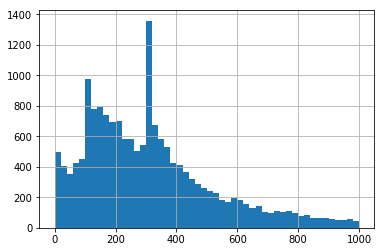

In [39]:
print(panier_moyen["Price"].describe())
panier_moyen["Price"].hist(range = (0, 1000), bins=50)

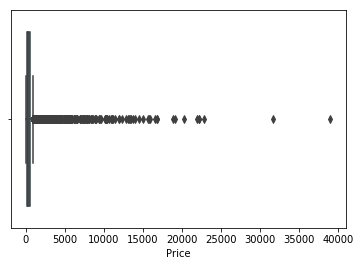

In [40]:
sns.boxplot(x=panier_moyen["Price"])

On ne va pas supprimer les points suivant pour eviter de supprimer des achat potentiellement vrais bien que gros (par exemple des acahts pro). On avait regardé precedeement les acahts en grande qté, ceux remboursés, ainsi que les produits très chers qui sont en fait des frais de ports)

## Analyse du CA

A titre informatif, on peut regarder le C/A par jour de la semaine de l'année et le moment de la journée et d'ou sont issues le CA

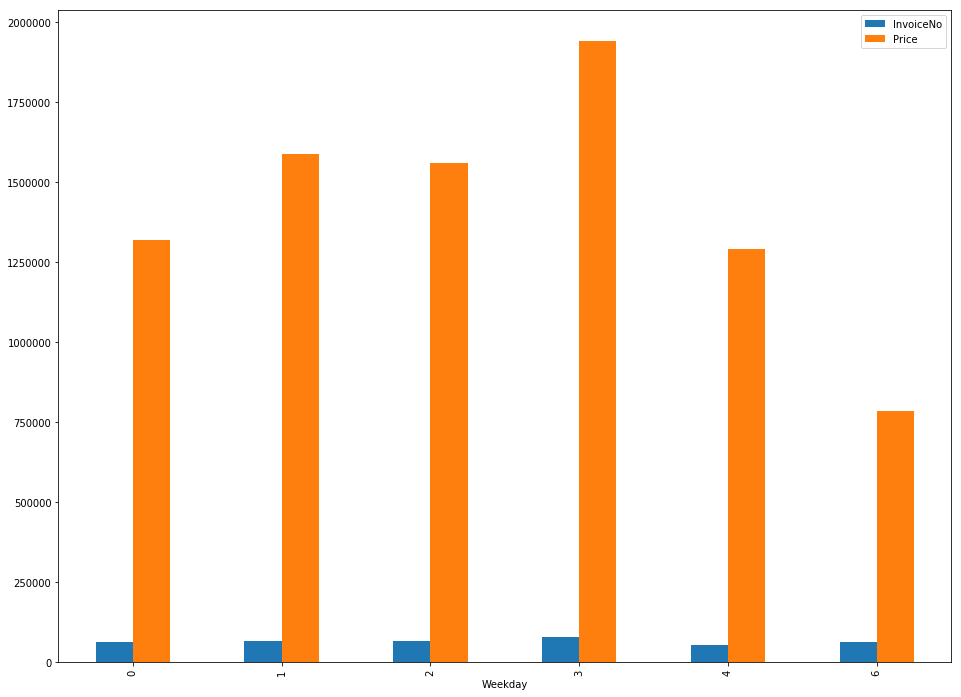

In [41]:
analyse_jour = df.groupby("Weekday").agg({
    "InvoiceNo" : "count",
    "Price" : "sum"
})
analyse_jour.plot(kind="bar", figsize=(16,12))  #http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

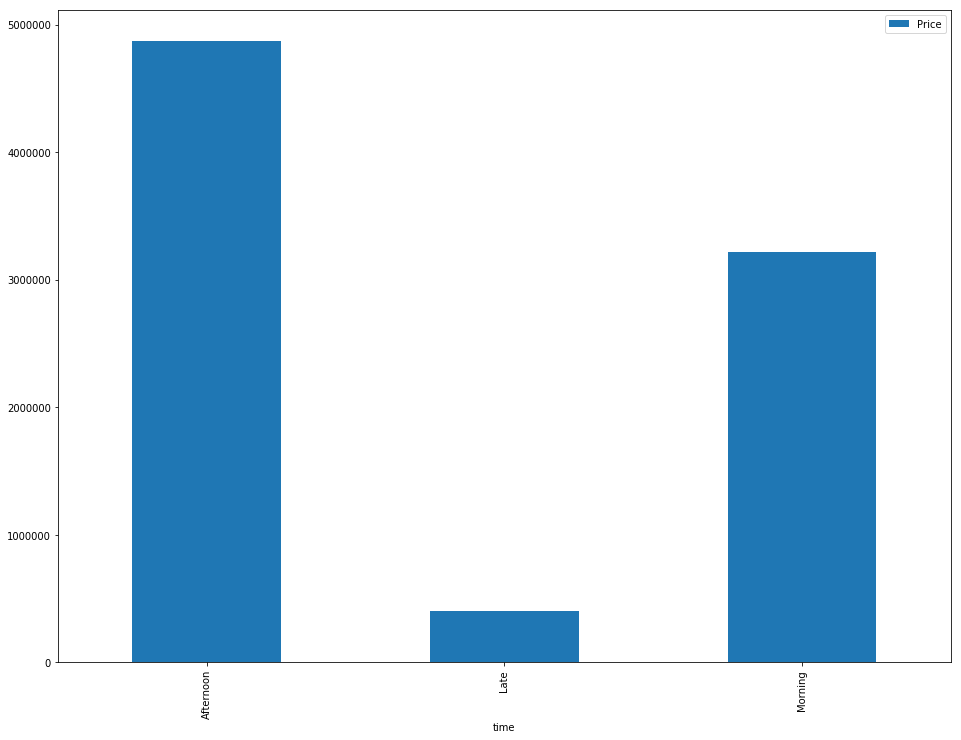

In [42]:
Cat_col = df[["Morning", "Afternoon", "Late"]].idxmax(axis=1)
s2 = pd.concat([Cat_col, df["Price"]], axis=1)
s2.columns=["time", "Price"]
s2
analyse_time = s2.groupby("time").agg({
    "Price" : "sum"
})
analyse_time
analyse_time.plot(kind="bar", figsize=(16,12))

Comme imaginable on retrouve un pic vers noel. Concernant les ventes on peut classer les pays en fonction de leur apport dans le CA

# Modélisation

Afin d'effectuer le clustering, on va réutiliser le principe du RFM mais avec plus de features. On peut notament penser à :

<li>Panier Moyen par visite</li>
<li>Nombre d'article moyen par visite</li>
<li>Prix moyen des articles par visite</li>
<li>Durée moyenne entre les visites</li>
<li>Dernière visite</li>
<li>Nombre de visite</li>
<li>Pays</li>
<li>Prix dépensé dans chaque cluster d'article</li>
<li>Prix dépensé par jour ou moment de la journée</li>

On doit donc finir de préparer le dataset

In [51]:
df["nb_visits"] = 0
df["price_avg_visits"] = 0
df["recency"] = 0
df["avg_cart"] = 0
df["freq_visit"] = 0
df = pd.concat([df, pd.get_dummies(df["Cluster"], prefix="Cluster_"), pd.get_dummies(df["Weekday"], prefix="Weekday_")], axis=1)

In [52]:
df.drop(["Cluster", "Weekday"], axis=1, inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395143 entries, 0 to 403662
Data columns (total 31 columns):
InvoiceNo           395143 non-null int64
Quantity            395143 non-null int64
UnitPrice           395143 non-null float64
CustomerID          395143 non-null float64
Country             395143 non-null int64
Afternoon           395143 non-null int64
Late                395143 non-null int64
Morning             395143 non-null int64
Recency             395143 non-null float64
Price               395143 non-null float64
nb_visits           395143 non-null int64
price_avg_visits    395143 non-null int64
recency             395143 non-null int64
avg_cart            395143 non-null int64
freq_visit          395143 non-null int64
Cluster__0          395143 non-null uint8
Cluster__1          395143 non-null uint8
Cluster__2          395143 non-null uint8
Cluster__3          395143 non-null uint8
Cluster__4          395143 non-null uint8
Cluster__5          395143 non-null uint8

In [26]:
# for col in df:
#     if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
#         df[col] = df[col] * df["Price"]

In [27]:
#df.drop(["Price"], axis=1, inplace=True)

In [46]:
df.set_index("InvoiceNo").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395143 entries, 536522 to 581101
Data columns (total 30 columns):
Quantity            395143 non-null int64
UnitPrice           395143 non-null float64
CustomerID          395143 non-null float64
Country             395143 non-null int64
Afternoon           395143 non-null int64
Late                395143 non-null int64
Morning             395143 non-null int64
Recency             395143 non-null float64
Price               395143 non-null float64
nb_visits           395143 non-null int64
price_avg_visits    395143 non-null int64
recency             395143 non-null int64
avg_cart            395143 non-null int64
freq_visit          395143 non-null int64
Cluster__0          395143 non-null uint8
Cluster__1          395143 non-null uint8
Cluster__2          395143 non-null uint8
Cluster__3          395143 non-null uint8
Cluster__4          395143 non-null uint8
Cluster__5          395143 non-null uint8
Cluster__6          395143 non-null 

In [57]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = lambda x:x.iloc[0]
custom_aggregation["nb_visits"] = lambda x:1
custom_aggregation["freq_visit"] = lambda x:1
for col in df:
    if col.startswith(("Cluster", "Weekday")):
        custom_aggregation[col] = "sum"
    elif col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "mean"

partial_df = df.groupby("InvoiceNo").agg(custom_aggregation)

In [58]:
partial_df

,Price,CustomerID,Country,Quantity,Recency,nb_visits,freq_visit,Afternoon,Late,Morning,...,Cluster__6,Cluster__7,Cluster__8,Cluster__9,Weekday__0,Weekday__1,Weekday__2,Weekday__3,Weekday__4,Weekday__6
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,139.12,17850.0,0,40,373.0,1,1,0.0,0,1.0,...,3.0,0,0,1,0.0,0.0,7.0,0.0,0,0.0
536366,22.20,17850.0,0,12,373.0,1,1,0.0,0,1.0,...,2.0,0,0,0,0.0,0.0,2.0,0.0,0,0.0
536367,278.73,13047.0,0,83,373.0,1,1,0.0,0,1.0,...,9.0,0,0,0,0.0,0.0,12.0,0.0,0,0.0
536368,70.05,13047.0,0,15,373.0,1,1,0.0,0,1.0,...,3.0,0,0,1,0.0,0.0,4.0,0.0,0,0.0
536369,17.85,13047.0,0,3,373.0,1,1,0.0,0,1.0,...,1.0,0,0,0,0.0,0.0,1.0,0.0,0,0.0
536370,801.86,12583.0,4,446,373.0,1,1,0.0,0,1.0,...,12.0,0,0,3,0.0,0.0,19.0,0.0,0,0.0
536371,204.00,13748.0,0,80,373.0,1,1,0.0,0,1.0,...,1.0,0,0,0,0.0,0.0,1.0,0.0,0,0.0
536372,22.20,17850.0,0,12,373.0,1,1,0.0,0,1.0,...,2.0,0,0,0,0.0,0.0,2.0,0.0,0,0.0
536373,259.86,17850.0,0,88,373.0,1,1,0.0,0,1.0,...,10.0,0,0,1,0.0,0.0,16.0,0.0,0,0.0


In [59]:
custom_aggregation = {}
custom_aggregation["nb_visits"] = "count"
custom_aggregation["Quantity"] = "mean"
custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["freq_visit"] = lambda x:1
custom_aggregation["Price"] = "mean"
custom_aggregation["Country"] = lambda x:x.iloc[0]
for col in df:
    if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "sum"
custom_aggregation

{'Afternoon': 'sum',
 'Cluster__0': 'sum',
 'Cluster__1': 'sum',
 'Cluster__2': 'sum',
 'Cluster__3': 'sum',
 'Cluster__4': 'sum',
 'Cluster__5': 'sum',
 'Cluster__6': 'sum',
 'Cluster__7': 'sum',
 'Cluster__8': 'sum',
 'Cluster__9': 'sum',
 'Country': <function __main__.<lambda>>,
 'Late': 'sum',
 'Morning': 'sum',
 'Price': 'mean',
 'Quantity': 'mean',
 'Recency': ['min', 'max'],
 'Weekday__0': 'sum',
 'Weekday__1': 'sum',
 'Weekday__2': 'sum',
 'Weekday__3': 'sum',
 'Weekday__4': 'sum',
 'Weekday__6': 'sum',
 'freq_visit': <function __main__.<lambda>>,
 'nb_visits': 'count'}

In [60]:
final_df = partial_df.groupby("CustomerID").agg(custom_aggregation)
final_df["freq_visit"] = (final_df["Recency", "max"] - final_df["Recency", "min"])/final_df["nb_visits", "count"]

In [61]:
#final_df.columns = [' '.join(col).strip() for col in df.columns.values]
final_df.columns = [
    'nb_visits', 
    'Quantity', 
    'Recency_min', 
    'Recency_max', 
    'freq_visit', 
    'Avg_Price', 
    'Country', 
    'Afternoon', 
    'Late', 
    'Morning', 
    'Cluster__0', 
    'Cluster__1', 
    'Cluster__2', 
    'Cluster__3', 
    'Cluster__4', 
    'Cluster__5', 
    'Cluster__6', 
    'Cluster__7', 
    'Cluster__8', 
    'Cluster__9', 
    'Weekday__0', 
    'Weekday__1', 
    'Weekday__2', 
    'Weekday__3', 
    'Weekday__4', 
    'Weekday__6'
]

In [66]:
final_df

,nb_visits,Quantity,Recency_min,Recency_max,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,...,Cluster__6,Cluster__7,Cluster__8,Cluster__9,Weekday__0,Weekday__1,Weekday__2,Weekday__3,Weekday__4,Weekday__6
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,7,351.142857,1.0,366.0,52.142857,615.714286,23,5.0,0,2.0,...,134.0,4,0,8.0,47.0,53.0,40.0,42.0,0.0,0.0
12348.0,4,583.000000,74.0,357.0,70.750000,359.310000,14,1.0,1,2.0,...,20.0,0,0,3.0,0.0,9.0,0.0,16.0,0.0,2.0
12349.0,1,630.000000,18.0,18.0,0.000000,1457.550000,16,0.0,0,1.0,...,43.0,0,0,17.0,72.0,0.0,0.0,0.0,0.0,0.0
12350.0,1,196.000000,309.0,309.0,0.000000,294.400000,11,1.0,0,0.0,...,12.0,0,0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
12352.0,7,75.142857,35.0,296.0,37.285714,197.962857,11,7.0,0,0.0,...,52.0,1,0,15.0,0.0,28.0,28.0,21.0,0.0,0.0
12353.0,1,20.000000,203.0,203.0,0.000000,89.000000,35,0.0,1,0.0,...,4.0,0,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
12354.0,1,530.000000,231.0,231.0,0.000000,1079.400000,7,1.0,0,0.0,...,45.0,0,0,8.0,0.0,0.0,0.0,58.0,0.0,0.0
12355.0,1,240.000000,213.0,213.0,0.000000,459.400000,35,1.0,0,0.0,...,9.0,4,0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
12356.0,3,524.333333,22.0,325.0,101.000000,829.143333,12,1.0,0,2.0,...,34.0,3,0,16.0,0.0,35.0,0.0,2.0,21.0,0.0


In [63]:
final_df.to_csv("final_df.csv")

# Mise en place du Clustering

In [64]:
final_df = pd.read_csv("final_df.csv", index_col=0)

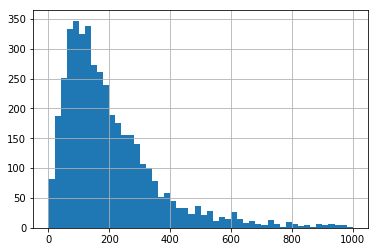

In [65]:
final_df["Quantity"].hist(bins=50, range = (0, 1000))

### Kmeans

In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(final_df)

In [68]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_std_scaled)
    clusters = kmeans.predict(X_std_scaled)
    silhouette_avg = silhouette_score(X_std_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.598375331901
For n_clusters = 4 The average silhouette_score is : 0.189947460524
For n_clusters = 5 The average silhouette_score is : 0.190682447469
For n_clusters = 6 The average silhouette_score is : 0.204376773955
For n_clusters = 7 The average silhouette_score is : 0.204377910986
For n_clusters = 8 The average silhouette_score is : 0.208694921519
For n_clusters = 9 The average silhouette_score is : 0.212753810931
For n_clusters = 10 The average silhouette_score is : 0.219735880488
For n_clusters = 11 The average silhouette_score is : 0.220518814753
For n_clusters = 12 The average silhouette_score is : 0.221640375281
For n_clusters = 13 The average silhouette_score is : 0.223078609824
For n_clusters = 14 The average silhouette_score is : 0.218378946551


In [7]:
scaler = MinMaxScaler()
X_minmax_scaled = scaler.fit_transform(final_df)

for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_minmax_scaled)
    clusters = kmeans.predict(X_minmax_scaled)
    silhouette_avg = silhouette_score(X_minmax_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.470740112922
For n_clusters = 4 The average silhouette_score is : 0.394404861271
For n_clusters = 5 The average silhouette_score is : 0.35068837067
For n_clusters = 6 The average silhouette_score is : 0.35685744636
For n_clusters = 7 The average silhouette_score is : 0.370578150525
For n_clusters = 8 The average silhouette_score is : 0.377401397872
For n_clusters = 9 The average silhouette_score is : 0.350967085372
For n_clusters = 10 The average silhouette_score is : 0.319894939475
For n_clusters = 11 The average silhouette_score is : 0.333215538009
For n_clusters = 12 The average silhouette_score is : 0.287859747888
For n_clusters = 13 The average silhouette_score is : 0.263727029247
For n_clusters = 14 The average silhouette_score is : 0.270657155331


In [69]:
kmeans = KMeans(init='k-means++', n_clusters = 4, n_init=30)
X_embedded = kmeans.fit_transform(X_std_scaled)
final_df["Customer_group"] = kmeans.labels_

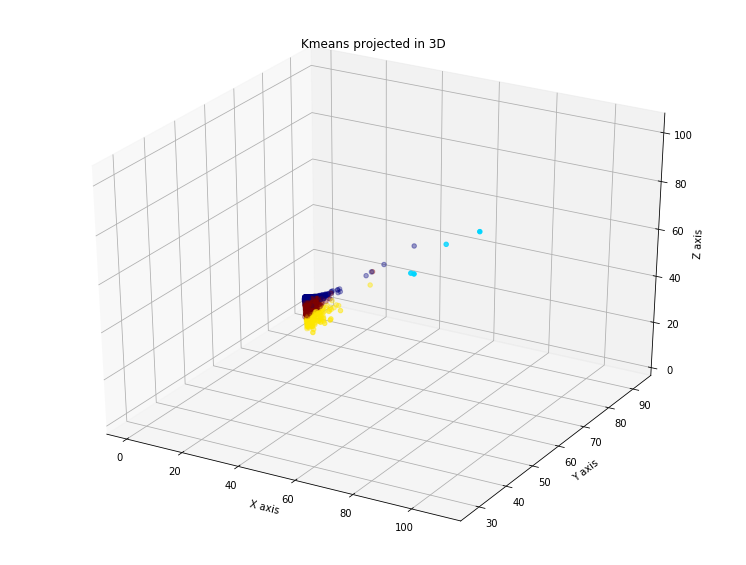

In [70]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
plt.title("Kmeans projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/kmeans3d.png")
plt.show()

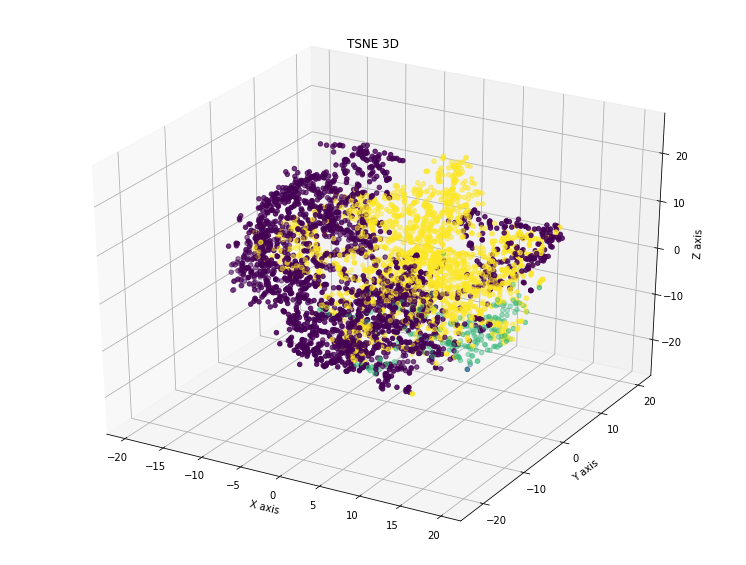

In [79]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X_std_scaled)
color = kmeans.labels_

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=color)
ax.set_title("TSNE 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/TSNE_3D.png")
plt.show()

# plt.figure(figsize=(13,10))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
# plt.show()

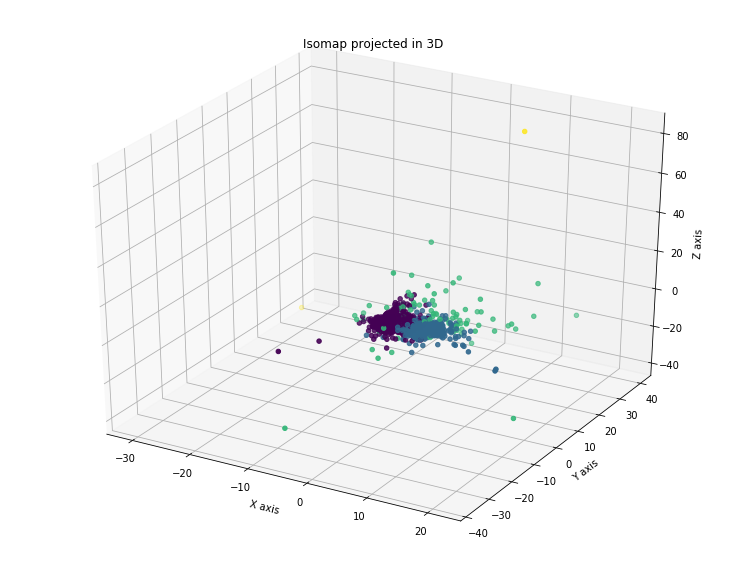

In [11]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=10, n_components=3)
pos = iso.fit_transform(X_std_scaled)

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
ax.set_title("Isomap projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/isomap3d.png")
plt.show()

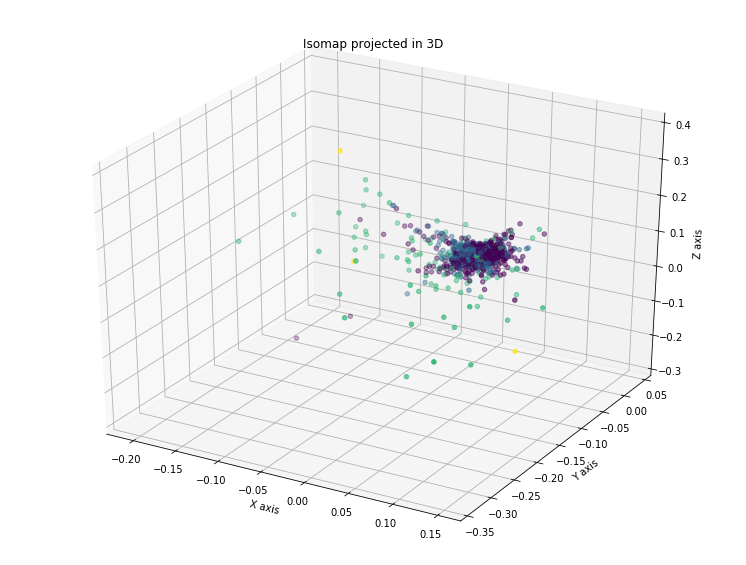

In [12]:
from sklearn.manifold import locally_linear_embedding
lle = locally_linear_embedding(X_std_scaled, n_neighbors=20, n_components=3)
pos = lle[0]
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
ax.set_title("Isomap projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/lle3d.png")
plt.show()

#### Exploration du résultat

In [71]:
def proportion(x):
    nb_abroad = x.astype(bool).sum(axis=0)
    nb_total = len(x)
    return (nb_total-nb_abroad)/nb_total

In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4333 entries, 12347.0 to 18287.0
Data columns (total 27 columns):
nb_visits         4333 non-null int64
Quantity          4333 non-null float64
Recency_min       4333 non-null float64
Recency_max       4333 non-null float64
freq_visit        4333 non-null float64
Avg_Price         4333 non-null float64
Country           4333 non-null int64
Afternoon         4333 non-null float64
Late              4333 non-null int64
Morning           4333 non-null float64
Cluster__0        4333 non-null float64
Cluster__1        4333 non-null float64
Cluster__2        4333 non-null float64
Cluster__3        4333 non-null int64
Cluster__4        4333 non-null int64
Cluster__5        4333 non-null int64
Cluster__6        4333 non-null float64
Cluster__7        4333 non-null int64
Cluster__8        4333 non-null int64
Cluster__9        4333 non-null float64
Weekday__0        4333 non-null float64
Weekday__1        4333 non-null float64
Weekday__2        

In [75]:
final_df["count_cluster"] = 1

visu = final_df.groupby("Customer_group").agg({
    "nb_visits" : "mean",
    "Quantity" : "mean",
    "Recency_min" : "mean",
    "freq_visit" : "mean",
    "Avg_Price" : "mean",
    "Country" : proportion,
    "Afternoon" : "sum",
    "Late" : "sum",
    "Morning" : "sum",
    "count_cluster" : "sum"
})

In [76]:
visu

,nb_visits,Quantity,Recency_min,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,count_cluster
Customer_group,,,,,,,,,,
0,1.572563,216.291469,135.922364,7.126350,349.344371,0.897662,2260.000000,175,1130.000000,2267
1,136.000000,417.998819,1.000000,3.121429,1080.278136,0.750000,347.000000,55,142.000000,4
2,20.293333,334.885189,13.013333,21.994347,575.571480,0.928889,2733.181818,231,1601.818182,225
3,5.283070,236.652332,46.847578,60.590401,388.511223,0.908002,5749.000000,404,3552.000000,1837


<li>Bon acheteurs peu fréquents</li>
<li>top clients, très fréquents et achetent beaucoup</li>
<li>bon clients, achetennt toute les 3 semaines environ pour pas mal d'argent</li>
<li>Clients peu fréquents</li>

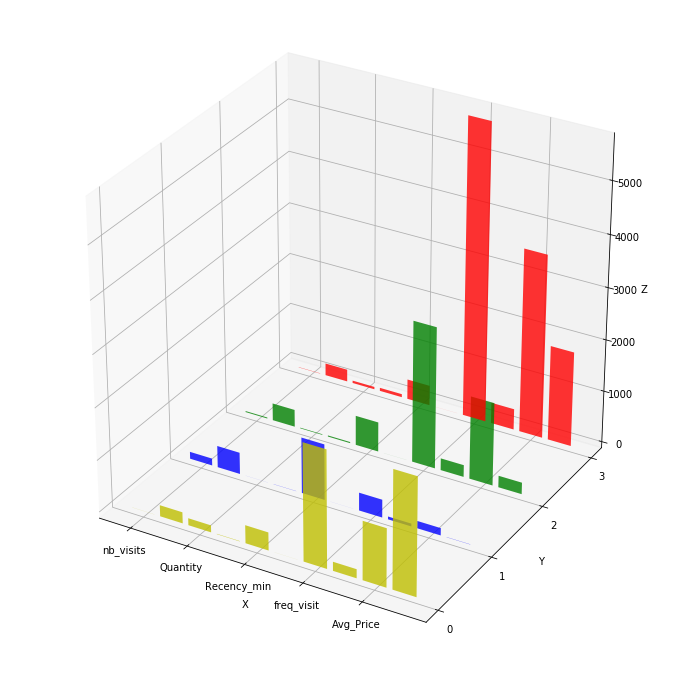

In [78]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', "k"]
yticks = [ 3, 2, 1, 0]
for c, k in zip(colors, yticks):
    xs = np.arange(10)
    ys = visu.as_matrix()[k, :]
    ax.bar(xs, ys, zs=k, zdir='y', color=c, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)
ax.set_xticklabels(list(visu))
plt.show()

In [80]:
final_df.to_csv("final_df_with_cluster.csv")

# Classifieur

In [83]:
final_df = pd.read_csv("final_df_with_cluster.csv", index_col=0)

In [86]:
X = final_df.drop(["count_cluster", "Customer_group"], axis=1)
y = final_df["Customer_group"] 

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(X)

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std_scaled, y, test_size=0.15, random_state=42)

## KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier

for voisin in range(1,12):
    neigh = KNeighborsClassifier(n_neighbors=voisin)
    neigh.fit(X_train_std, y_train_std) 
    print(voisin, neigh.score(X_test_std, y_test_std))

1 0.952307692308
2 0.946153846154
3 0.952307692308
4 0.952307692308
5 0.955384615385
6 0.958461538462
7 0.961538461538
8 0.958461538462
9 0.96
10 0.963076923077
11 0.956923076923


## SVC

In [100]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_std, y_train_std) 
print(clf.score(X_test_std, y_test_std))

0.981538461538


## Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_std, y_train_std)
print(gnb.score(X_test_std, y_test_std))

0.863076923077


## Decision Tree

In [108]:
from sklearn.tree import DecisionTreeClassifier
for max_depth in range(3, 10):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    clf.fit(X_train_std, y_train_std)
    print(max_depth, clf.score(X_test_std, y_test_std))

3 0.903076923077
4 0.910769230769
5 0.924615384615
6 0.936923076923
7 0.955384615385
8 0.944615384615
9 0.950769230769


## Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier

for max_depth in range(3, 15):
    clf = RandomForestClassifier(random_state=0, max_depth=max_depth, n_estimators=50)
    clf.fit(X_train_std, y_train_std)
    print(max_depth, clf.score(X_test_std, y_test_std))

3 0.910769230769
4 0.921538461538
5 0.938461538462
6 0.944615384615
7 0.953846153846
8 0.963076923077
9 0.958461538462
10 0.958461538462
11 0.956923076923
12 0.970769230769
13 0.967692307692
14 0.961538461538


In [ ]:
http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest